### Import Libraries


In [2]:
%pip install torch torchvision matplotlib tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 346.8 kB/s eta 0:00:0000:0100:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 427.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 564.5 kB/s eta 0:00:0000:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 552.0 kB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.utils.data import DataLoader, Subset
import gzip
import os


### CNN Model


In [29]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Data Partitioning


In [ ]:
def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    save_dir = "../data/client_dataset"
    BATCH_SIZE = 64

    if only_server_test_data:
        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        )
        return DataLoader(testset, batch_size=BATCH_SIZE, num_workers=8)

    client_filenames = [
        os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
        os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
    ]
    for path in client_filenames:
        if os.path.exists(path):
            partition_data_path = path
            break
    else:
        raise FileNotFoundError(f"No data file for client {partition_id}")

    with gzip.open(partition_data_path, 'rb') as f:
        device_data = torch.load(f, map_location='cpu')
    device_data = [(x.to(torch.float32), y) for x,y in device_data]
    np.random.shuffle(device_data)
    split = int(len(device_data)*0.8)
    train_data, test_data = device_data[:split], device_data[split:]

    normalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    train_data = [(normalize(x), y) for x,y in train_data]
    test_data  = [(normalize(x), y) for x,y in test_data]

    trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
    valloader  = DataLoader(test_data,  batch_size=BATCH_SIZE, num_workers=1)
    return trainloader, valloader



### Train Local Model Function


In [36]:
# Parameters
FL_ROUNDS = 20
LOCAL_EPOCHS = 3
NUM_CLIENTS = 50

In [32]:
def train_local(client_id, global_model, train_loader, epochs=1, device='cpu'):

    model = copy.deepcopy(global_model).to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):

        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / total
        accuracy = 100. * correct / total
        print(f" Client {client_id} Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    return model.state_dict()


def test_model(model, testloader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return accuracy, avg_loss


### Aggregation Algorithms


In [33]:
# Weight Divergence Calculation
def calculate_weight_divergence(ref_params, client_params):
    divergence = 0.0
    for key in ref_params.keys():
        divergence += torch.norm(ref_params[key] - client_params[key]) ** 2
    return torch.sqrt(divergence).item()


def calculate_normalized_weight_divergence(ref_params, client_params):
    numerator = 0.0
    denominator = 0.0

    for key in client_params:
        diff = client_params[key] - ref_params[key]
        numerator += torch.norm(diff, p=2).item() ** 2
        denominator += torch.norm(ref_params[key], p=2).item() ** 2

    numerator = numerator ** 0.5
    denominator = denominator ** 0.5

    if denominator == 0:
        return 0.0  # Avoid division by zero

    return numerator / denominator


def weighted_fed_avg(models_params, weights):
    avg_params = copy.deepcopy(models_params[0])
    total_weight = sum(weights)
    for param_key in avg_params:
        weighted_sum = 0.0
        for i in range(len(models_params)):
            client_param = models_params[i][param_key]
            weight = weights[i]
            weighted_sum += client_param * weight
        avg_params[param_key] = weighted_sum / total_weight
    return avg_params

### Federated Training


In [ ]:
# Create reference client (fully IID)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
ref_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

reference_loader = DataLoader(ref_trainset, batch_size=64, shuffle=True)

In [35]:
# Initialize global model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = Net().to(device)

In [ ]:
# Federated Training Loop

accuracy_list = []
loss_list = []
weight_divergences_list = []

for fl_round in range(FL_ROUNDS):
    print(f"\n--- Federated Learning Round {fl_round+1} ---")

    # Train reference client
    print(f"\n Reference Client Training:")
    reference_params = train_local("ref" ,global_model, reference_loader, epochs=LOCAL_EPOCHS, device=device)

    # Train all clients
    local_params = []
    for i in range(NUM_CLIENTS):
        print(f"\n Client {i}: Local Training")
        print("--------------------------------------------------")

        # Load client dataloaders
        client_trainloader, _ = load_data_from_disk(i)

        client_params = train_local(i, global_model, client_trainloader, epochs=LOCAL_EPOCHS, device=device)
        local_params.append(client_params)

    # Compute weight divergences
    weight_divergences = []
    for client_params in local_params:
        weight_divergence = calculate_normalized_weight_divergence(reference_params, client_params)
        weight_divergences.append(weight_divergence)
    print(f"\n Divergence : {weight_divergences}")
    weight_divergences_list.append(weight_divergences)

    # Normalize divergences to get weights
    d_min = min(weight_divergences)
    d_max = max(weight_divergences)
    weights = [(1 - (d - d_min) / (d_max - d_min)) for d in weight_divergences]
    print(f"\n IId Nature Measure : {weights}")

    # Aggregate
    global_params = weighted_fed_avg(local_params, weights)
    global_model.load_state_dict(global_params)

    # Test
    test_loader = load_data_from_disk(0, only_server_test_data=True)  # Load server test data
    accuracy, loss = test_model(global_model, test_loader, device=device)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    
    print(f"\nFederated Learning Round {fl_round+1}:")
    print(f"  Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")


--- Federated Learning Round 1 ---

 Client 0: Local Training
--------------------------------------------------
 Client 0 Epoch 1: Loss = 1.5440, Accuracy = 50.84%
 Client 0 Epoch 2: Loss = 0.8982, Accuracy = 53.89%
 Client 0 Epoch 3: Loss = 0.6764, Accuracy = 62.36%

 Client 1: Local Training
--------------------------------------------------
 Client 1 Epoch 1: Loss = 1.4105, Accuracy = 48.47%
 Client 1 Epoch 2: Loss = 0.6838, Accuracy = 60.45%
 Client 1 Epoch 3: Loss = 0.6712, Accuracy = 61.50%

 Client 2: Local Training
--------------------------------------------------
 Client 2 Epoch 1: Loss = 3.8055, Accuracy = 57.72%
 Client 2 Epoch 2: Loss = 0.8464, Accuracy = 57.23%
 Client 2 Epoch 3: Loss = 0.6849, Accuracy = 61.41%

 Client 3: Local Training
--------------------------------------------------
 Client 3 Epoch 1: Loss = 2.2768, Accuracy = 48.57%
 Client 3 Epoch 2: Loss = 0.7769, Accuracy = 48.65%
 Client 3 Epoch 3: Loss = 0.6946, Accuracy = 52.55%

 Client 4: Local Training
-

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaanumacbook/FYP/Implementations/FL-Implimentation/.venv/lib/python3.11/site-packages/torch/__init__.py", line 409, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 216, in _lock_unlock_module
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
import pickle

with open('/kaggle/working/weight_divergence_accuracy_history.pkl', 'wb') as f:
    pickle.dump(accuracy_list, f)

with open('/kaggle/working/weight_divergence_history.pkl', 'wb') as f:
    pickle.dump(weight_divergences_list, f)


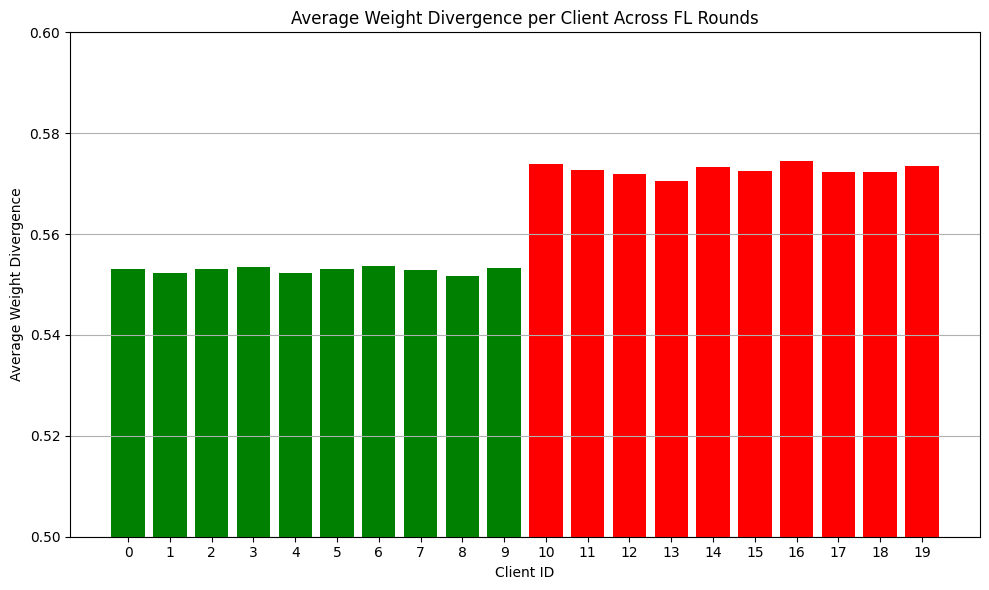

In [26]:

# Convert to numpy array: shape [rounds, clients]
divergence_array = np.array(weight_divergences_list)

# Compute average divergence per client
average_divergence_per_client = divergence_array.mean(axis=0)

# Assign colors: first 10 red, rest green
colors = ['green' if i < 10 else 'red' for i in range(len(average_divergence_per_client))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_divergence_per_client)), average_divergence_per_client, color=colors)
plt.xlabel("Client ID")
plt.ylabel("Average Weight Divergence")
plt.title("Average Weight Divergence per Client Across FL Rounds")
plt.xticks(range(len(average_divergence_per_client)))
plt.ylim(0.5, 0.6)  # Zoomed-in view
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Plot Accuracy Curve


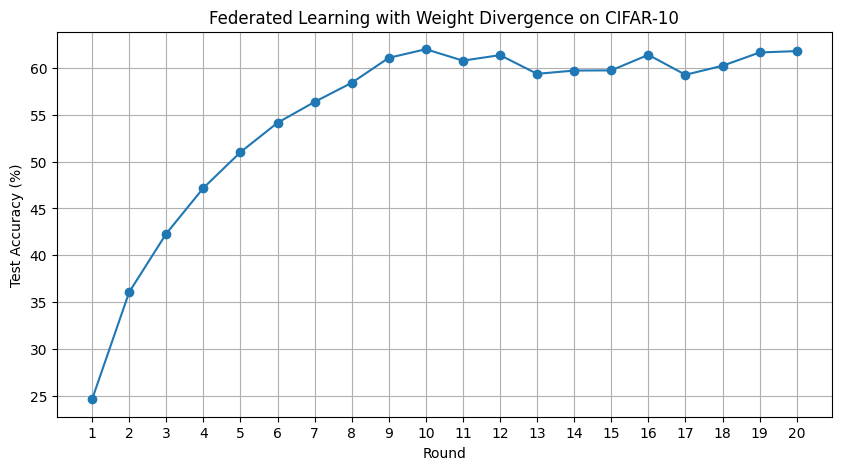

In [38]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, FL_ROUNDS + 1), accuracy_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Federated Learning with Weight Divergence on CIFAR-10')
plt.grid(True)
plt.xticks(range(1, 21))  # Set x-axis from 1 to 20
plt.show()
